# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [45]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [46]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries']

df = df[features_tokeep]

recoveries = df[['id', 'recoveries', 'loan_amnt', 'int_rate']]

df.drop(columns = ['recoveries'], inplace=True)
df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
df = df.sample(200000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(200000, 68)

1.9110486507415771

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,12697550,Fully Paid,8400.0,8400.0,8400.0,36.0,11.99,278.970001,2014-03-01,debt_consolidation,Debt consolidation,f,Individual,B,B3,694.0,Project Analyst,6 years,RENT,90000.0,233xx,VA,6.33,Source Verified,7.0,9.0,9.0,58.0,NaN,NaN,2.0,Jul-2003,3.0,NaN,NaN,10.0,4.0,7.0,26.0,30290.0,302900.0,5177.0,70.9,1600.0,7.0,4.0,5.0,7300.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,39344.0,0.0,0.0,0.000000,100.000000,NaN,NaN,1.0,0.0,0.0,1.0,2014.0
1,11675582,Fully Paid,17000.0,17000.0,17000.0,36.0,13.98,580.859985,2014-02-01,debt_consolidation,Debt consolidation,f,Individual,C,C1,679.0,Senior Financial Analyst,10+ years,RENT,86000.0,930xx,CA,16.52,Source Verified,4.0,65.0,65.0,NaN,NaN,NaN,1.0,Jun-2002,0.0,NaN,NaN,6.0,2.0,5.0,21.0,6491.0,38944.0,11734.0,100.3,7.0,37.0,3.0,3.0,11700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,38944.0,0.0,0.0,100.000000,95.199997,NaN,NaN,0.0,0.0,0.0,1.0,2014.0
2,14560129,Fully Paid,10000.0,10000.0,10000.0,36.0,12.49,334.489990,2014-04-01,credit_card,Credit card refinancing,f,Individual,B,B4,679.0,Material Handler,8 years,MORTGAGE,24500.0,647xx,MO,14.16,Source Verified,14.0,17.0,NaN,NaN,NaN,17.0,0.0,Aug-2003,2.0,NaN,NaN,8.0,1.0,1.0,15.0,11136.0,89091.0,11028.0,55.4,4885.0,43.0,6.0,7.0,19900.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,11028.0,0.0,0.0,75.000000,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0
3,120141091,Current,5000.0,5000.0,5000.0,36.0,14.08,171.089996,2017-10-01,home_improvement,Home improvement,w,Joint App,C,C3,689.0,National Accounts Manager,< 1 year,MORTGAGE,160000.0,551xx,MN,21.17,Not Verified,9.0,62.0,NaN,NaN,62.0,62.0,1.0,Apr-1978,0.0,0.0,1.0,16.0,2.0,2.0,20.0,22515.0,360241.0,21287.0,94.8,1152.0,19.0,4.0,6.0,23800.0,0.0,0.0,0.0,0.0,0.0,242000.0,18.139999,Not Verified,212328.0,0.0,0.0,60.000000,82.400002,0.0,1.0,0.0,0.0,0.0,0.0,2017.0
4,151973778,Current,10000.0,10000.0,10000.0,36.0,17.19,357.480011,2019-05-01,debt_consolidation,Debt consolidation,w,Individual,C,C5,674.0,Engineering,5 years,RENT,92000.0,445xx,OH,12.14,Source Verified,16.0,10.0,NaN,NaN,NaN,NaN,0.0,Feb-2009,0.0,2.0,0.0,13.0,5.0,0.0,13.0,3861.0,50189.0,8321.0,46.7,6479.0,16.0,3.0,8.0,17800.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,50189.0,525.0,0.0,16.700001,90.000000,0.0,0.0,0.0,0.0,0.0,1.0,2019.0


## 3. Data preprocessing

In [47]:
### feature description:

#f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
#f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
#display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

In [48]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [49]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,12697550,Fully Paid,8400.0,8400.0,8400.0,36.0,11.99,278.970001,2014-03-01,debt_consolidation,Debt consolidation,f,Individual,B,B3,694.0,Project Analyst,6 years,RENT,90000.0,233xx,VA,6.33,Source Verified,7.0,9.0,9.0,58.0,NaN,NaN,2.0,2003-07-01,3.0,NaN,NaN,10.0,4.0,7.0,26.0,30290.0,302900.0,5177.0,70.9,1600.0,7.0,4.0,5.0,7300.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,39344.0,0.0,0.0,0.000000,100.000000,NaN,NaN,1.0,0.0,0.0,1.0,2014.0,3,2014,10.666886,0.093748
1,11675582,Fully Paid,17000.0,17000.0,17000.0,36.0,13.98,580.859985,2014-02-01,debt_consolidation,Debt consolidation,f,Individual,C,C1,679.0,Senior Financial Analyst,10+ years,RENT,86000.0,930xx,CA,16.52,Source Verified,4.0,65.0,65.0,NaN,NaN,NaN,1.0,2002-06-01,0.0,NaN,NaN,6.0,2.0,5.0,21.0,6491.0,38944.0,11734.0,100.3,7.0,37.0,3.0,3.0,11700.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,38944.0,0.0,0.0,100.000000,95.199997,NaN,NaN,0.0,0.0,0.0,1.0,2014.0,2,2014,11.671698,0.000000
2,14560129,Fully Paid,10000.0,10000.0,10000.0,36.0,12.49,334.489990,2014-04-01,credit_card,Credit card refinancing,f,Individual,B,B4,679.0,Material Handler,8 years,MORTGAGE,24500.0,647xx,MO,14.16,Source Verified,14.0,17.0,NaN,NaN,NaN,17.0,0.0,2003-08-01,2.0,NaN,NaN,8.0,1.0,1.0,15.0,11136.0,89091.0,11028.0,55.4,4885.0,43.0,6.0,7.0,19900.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,11028.0,0.0,0.0,75.000000,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,4,2014,10.666886,0.000000
3,120141091,Current,5000.0,5000.0,5000.0,36.0,14.08,171.089996,2017-10-01,home_improvement,Home improvement,w,Joint App,C,C3,689.0,National Accounts Manager,< 1 year,MORTGAGE,160000.0,551xx,MN,21.17,Not Verified,9.0,62.0,NaN,NaN,62.0,62.0,1.0,1978-04-01,0.0,0.0,1.0,16.0,2.0,2.0,20.0,22515.0,360241.0,21287.0,94.8,1152.0,19.0,4.0,6.0,23800.0,0.0,0.0,0.0,0.0,0.0,242000.0,18.139999,Not Verified,212328.0,0.0,0.0,60.000000,82.400002,0.0,1.0,0.0,0.0,0.0,0.0,2017.0,10,2017,39.502522,0.000000
4,151973778,Current,10000.0,10000.0,10000.0,36.0,17.19,357.480011,2019-05-01,debt_consolidation,Debt consolidation,w,Individual,C,C5,674.0,Engineering,5 years,RENT,92000.0,445xx,OH,12.14,Source Verified,16.0,10.0,NaN,NaN,NaN,NaN,0.0,2009-02-01,0.0,2.0,0.0,13.0,5.0,0.0,13.0,3861.0,50189.0,8321.0,46.7,6479.0,16.0,3.0,8.0,17800.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,50189.0,525.0,0.0,16.700001,90.000000,0.0,0.0,0.0,0.0,0.0,1.0,2019.0,5,2019,10.242510,0.000000


In [50]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             98853
Current                                                72716
Charged Off                                            25667
Late (31-120 days)                                      1133
In Grace Period                                          743
Late (16-30 days)                                        202
Does not meet the credit policy. Status:Fully Paid       145
Issued                                                   129
Does not meet the credit policy. Status:Charged Off       51
Default                                                   31
Name: loan_status, dtype: int64

(124551, 73)

Fully Paid                                             98853
Charged Off                                            25667
Default                                                   31
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

id                                124551
loan_status                       124551
loan_amnt                         124551
funded_amnt                       124551
funded_amnt_inv                   124551
term                              124551
int_rate                          124551
installment                       124551
issue_d                           124551
purpose                           124551
title                             123187
initial_list_status               124551
application_type                  124551
grade                             124551
sub_grade                         124551
fico_range_high                   124551
emp_title                         116095
emp_length                        116979
home_ownership                    124551
annual_inc                        124551
zip_code                          124551
addr_state                        124551
dti                               124493
verification_status               124551
mo_sin_rcnt_tl  

85.91614627838135

### 3. Feature Preprocessing

In [51]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    41353
2.0     11139
0.0     10292
3.0     10057
1.0      8092
5.0      7783
4.0      7608
6.0      5691
7.0      5182
8.0      5145
9.0      4637
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,12697550,8400.0,8400.0,8400.0,36.0,11.99,278.970001,debt_consolidation,Debt consolidation,f,Individual,B,B3,694.0,Project Analyst,6.0,RENT,90000.0,233,VA,6.330000,Source Verified,7.0,9.0,9.0,58.0,NaN,NaN,2.0,3.0,NaN,NaN,10.0,4.0,7.0,26.0,30290.0,302900.0,5177.0,70.9,1600.0,7.0,4.0,5.0,7300.0,1.0,0.0,0.0,1.0,0.0,39344.0,0.0,0.0,0.000000,100.000000,NaN,NaN,1.0,0.0,0.0,1.0,2014.0,3,2014,10.666886,0.093748,0.0,0.093333,0.037196,0,0.057522,0.336556,3.365556,0.437156,0.081111,0,0.384615,0
1,11675582,17000.0,17000.0,17000.0,36.0,13.98,580.859985,debt_consolidation,Debt consolidation,f,Individual,C,C1,679.0,Senior Financial Analyst,10.0,RENT,86000.0,930,CA,16.520000,Source Verified,4.0,65.0,65.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,6.0,2.0,5.0,21.0,6491.0,38944.0,11734.0,100.0,7.0,37.0,3.0,3.0,11700.0,0.0,0.0,0.0,0.0,0.0,38944.0,0.0,0.0,100.000000,95.199997,NaN,NaN,0.0,0.0,0.0,1.0,2014.0,2,2014,11.671698,0.000000,0.0,0.197674,0.081050,0,0.136442,0.075477,0.452837,0.452837,0.136047,0,0.285714,0
2,14560129,10000.0,10000.0,10000.0,36.0,12.49,334.489990,credit_card,Credit card refinancing,f,Individual,B,B4,679.0,Material Handler,8.0,MORTGAGE,24500.0,647,MO,14.160000,Source Verified,14.0,17.0,NaN,NaN,NaN,17.0,0.0,2.0,NaN,NaN,8.0,1.0,1.0,15.0,11136.0,89091.0,11028.0,55.4,4885.0,43.0,6.0,7.0,19900.0,1.0,0.0,0.0,0.0,0.0,11028.0,0.0,0.0,75.000000,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,4,2014,10.666886,0.000000,0.0,0.408163,0.163832,0,0.450122,0.454531,3.636367,0.450122,0.812245,0,0.533333,0
5,30816298,7700.0,7700.0,7700.0,36.0,12.49,257.559998,debt_consolidation,Debt consolidation,f,Individual,B,B5,684.0,Office Manager,2.0,OWN,20800.0,729,AR,28.510000,Source Verified,13.0,7.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,18.0,5.0,0.0,30.0,497.0,8444.0,3769.0,32.2,1379.0,13.0,10.0,17.0,11700.0,2.0,0.0,0.0,0.0,0.0,8444.0,188.0,0.0,33.299999,93.300003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,10,2014,7.419728,0.000000,1.0,0.370192,0.148592,0,0.181202,0.023894,0.405962,0.405962,0.562500,0,0.600000,0
7,3156420,11450.0,11450.0,11450.0,36.0,10.16,370.329987,credit_card,Credit Card Consolidation,f,Individual,B,B1,714.0,Rockwell American,7.0,MORTGAGE,64000.0,338,FL,24.299999,Not Verified,3.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,15.0,6.0,9.0,34.0,14824.0,222359.0,39297.0,75.3,7561.0,3.0,9.0,11.0,52200.0,0.0,0.0,0.0,0.0,0.0,56802.0,0.0,0.0,42.900002,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,1,2013,15.838792,0.000000,0.0,0.178906,0.069437,0,0.614016,0.231625,3.474359,0.887531,0.815625,0,0.441176,0


In [52]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



id                                124551
loan_amnt                         124551
funded_amnt                       124551
funded_amnt_inv                   124551
term                              124551
int_rate                          124551
installment                       124551
purpose                           124551
title                             123187
initial_list_status               124551
application_type                  124551
grade                             124551
sub_grade                         124551
fico_range_high                   124551
emp_title                         116095
emp_length                        116979
home_ownership                    124551
annual_inc                        124551
zip_code                          124551
addr_state                        124551
dti                               124493
verification_status               124551
mo_sin_rcnt_tl                    124551
mths_since_last_delinq            124551
mths_since_last_

In [53]:
df.mo_sin_rcnt_tl.describe()

count    124551.000000
mean         12.172685
std          22.734526
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         187.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [54]:
df.target.mean()

0.20632511983043092

In [55]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [56]:
df.application_type.value_counts()

Individual    120134
Joint App       4417
Name: application_type, dtype: int64

### 4. EDA

In [57]:
print('Bankruptcy incidnce is the sample is: ', df.target.mean())

Bankruptcy incidnce is the sample is:  0.20632511983043092


In [58]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,124551.000000,124551.000000,124551.000000
mean,14480.714844,14474.854492,14457.033203
std,8983.991211,8981.998047,8983.143555
min,1000.000000,1000.000000,0.000000
25%,7575.000000,7550.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    95373
60.0    29178
Name: term, dtype: int64

So the three amount features above are basically identical.

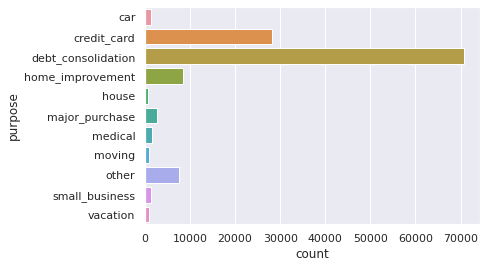

<AxesSubplot:xlabel='count', ylabel='emp_length'>

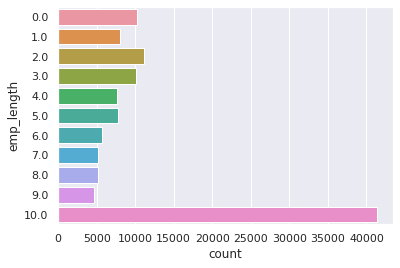

In [59]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [60]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

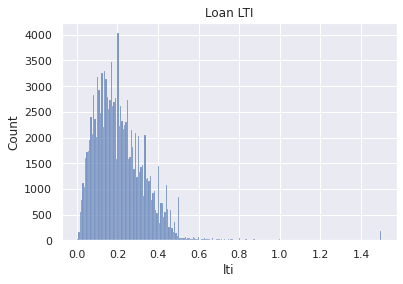

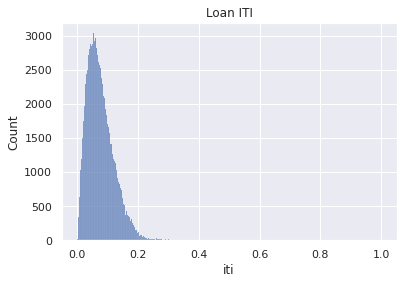

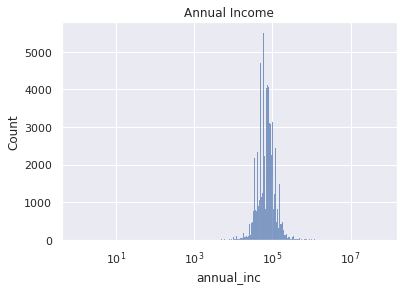

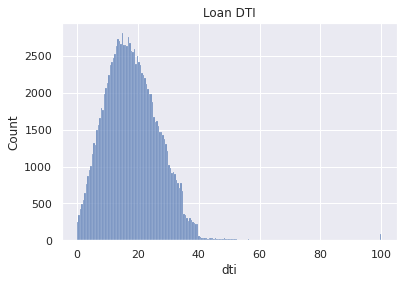

In [61]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [62]:
df.dti.describe()

count    124493.000000
mean         18.287102
std           9.233927
min           0.000000
25%          11.740000
50%          17.520000
75%          24.070000
max         100.000000
Name: dti, dtype: float64

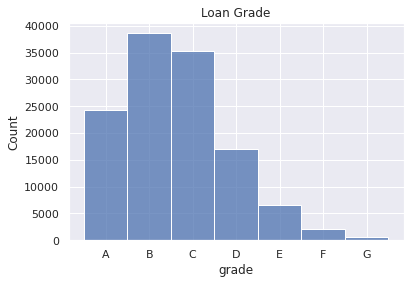

In [63]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

### EDA with target

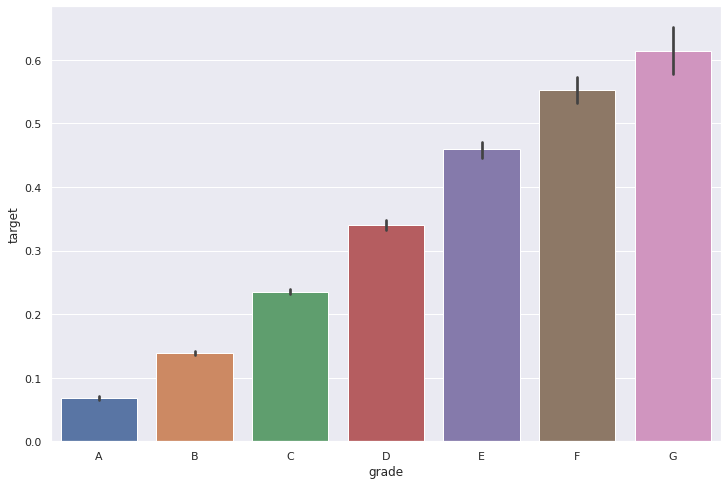

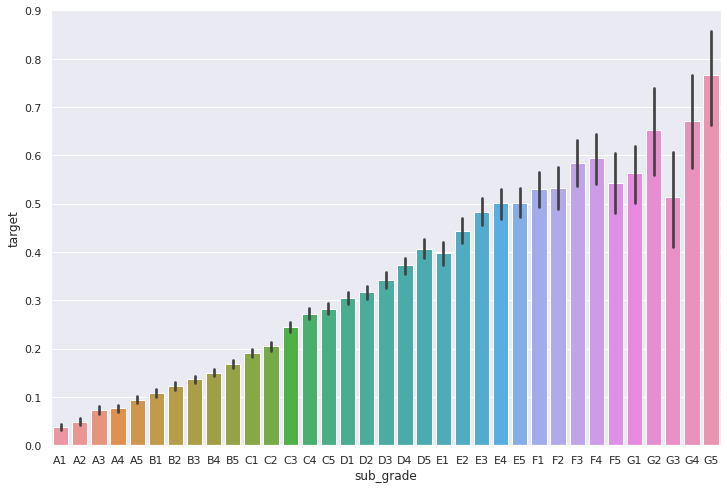

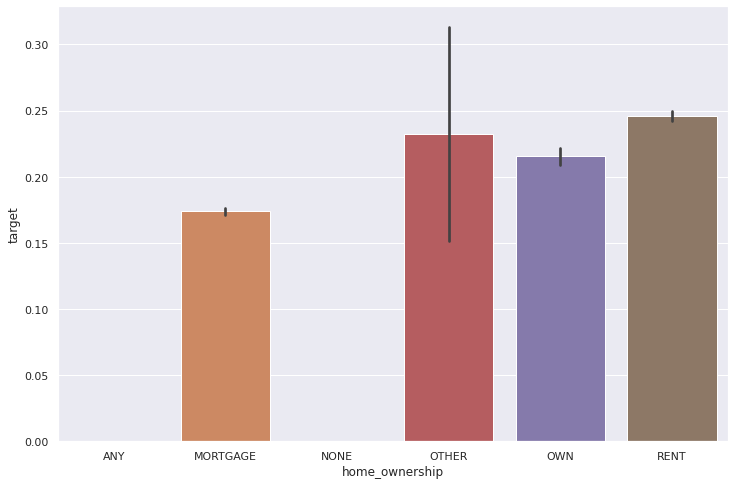

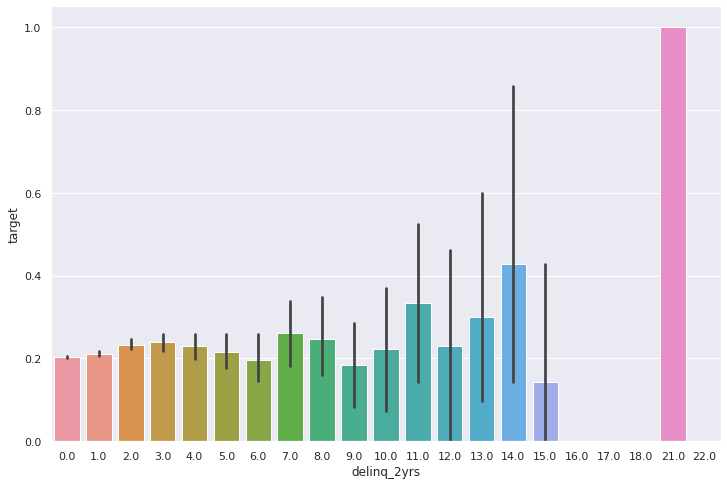

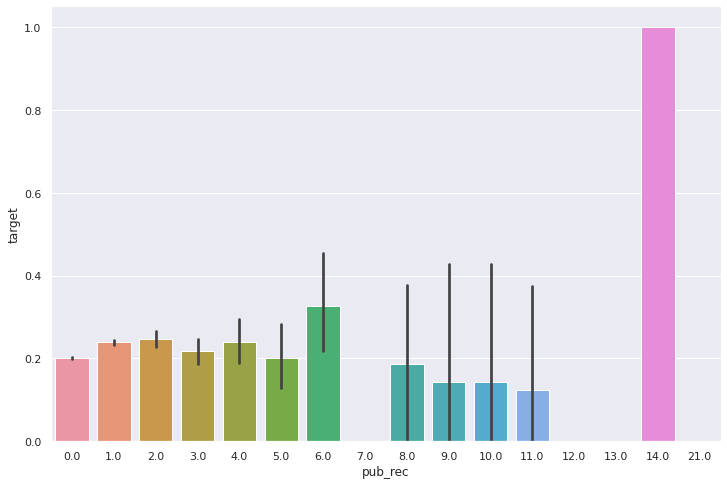

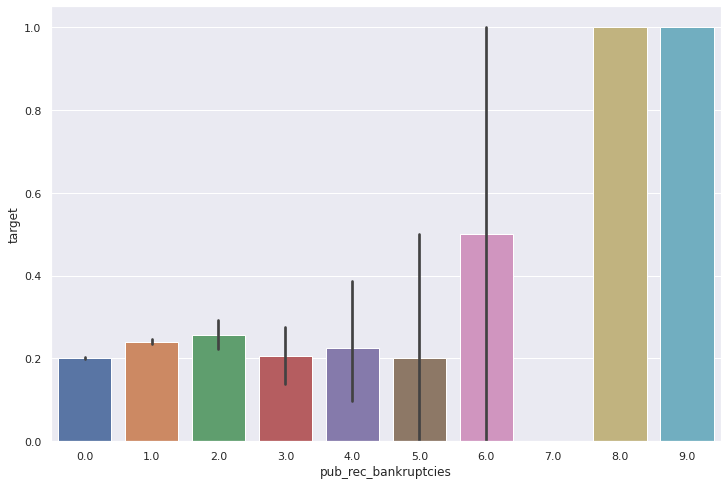

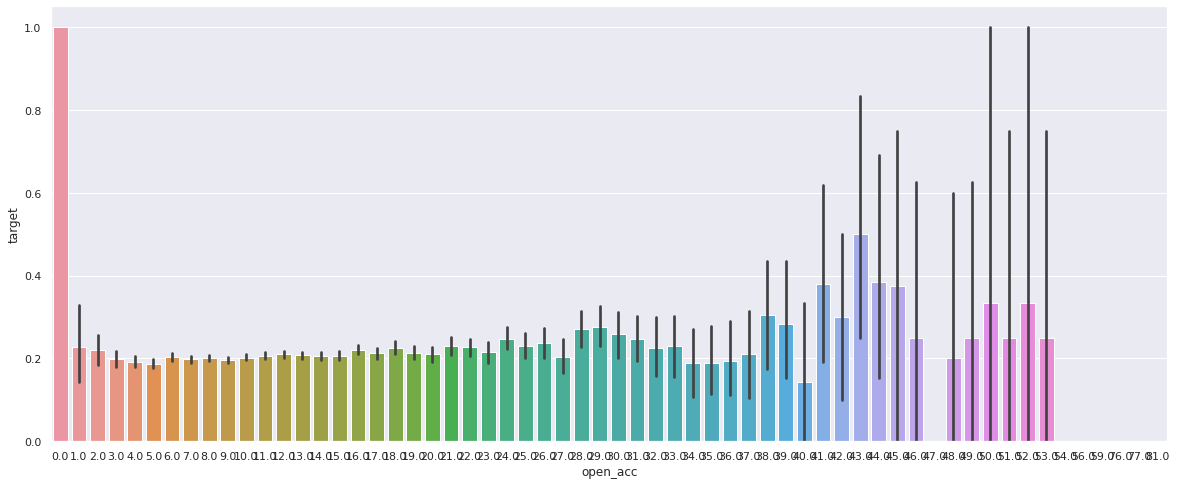

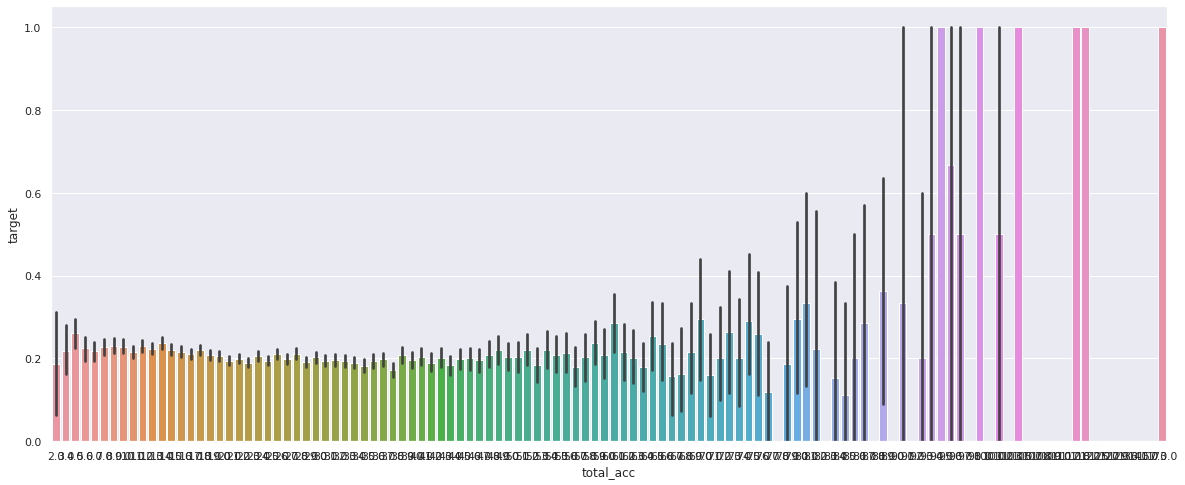

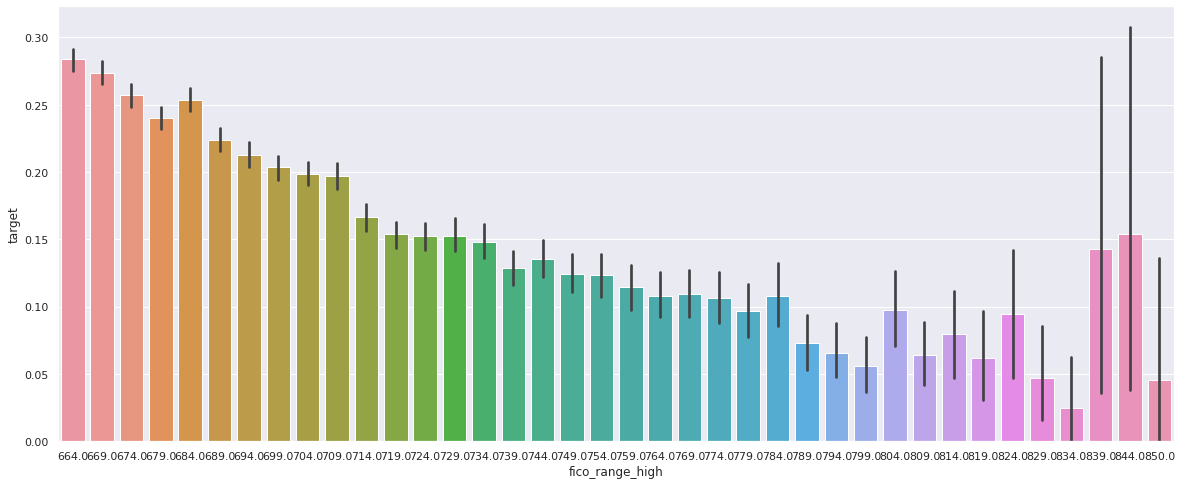

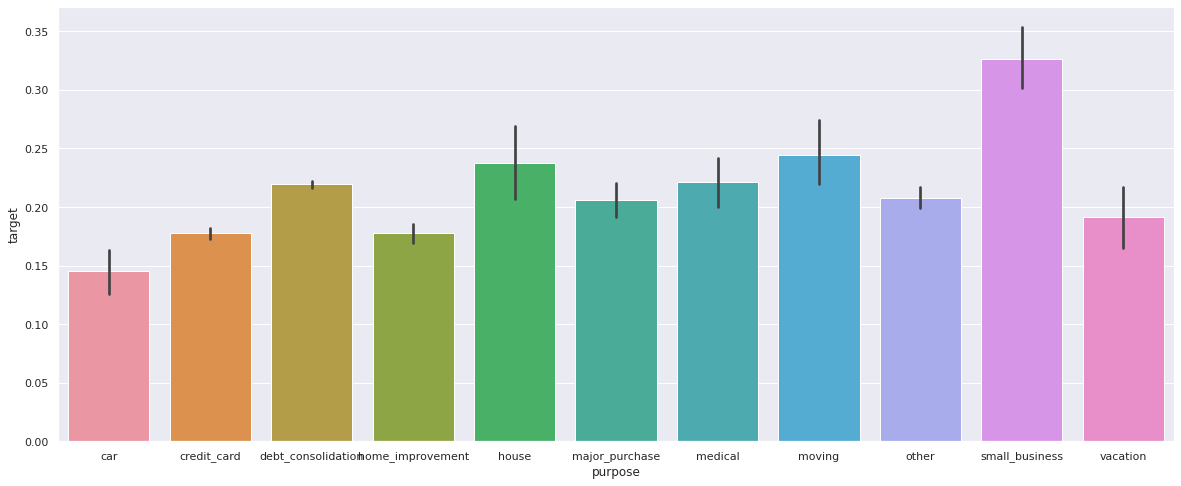

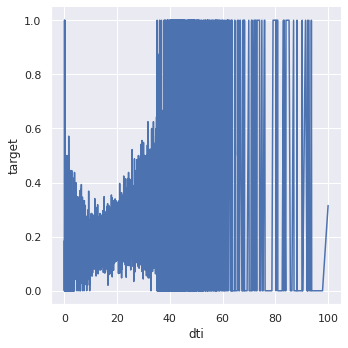

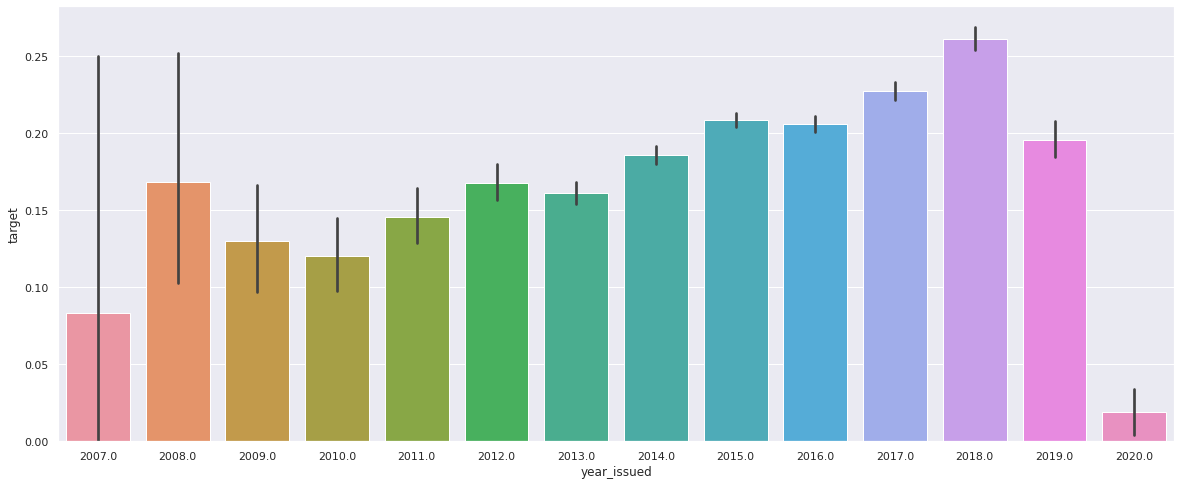

In [64]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

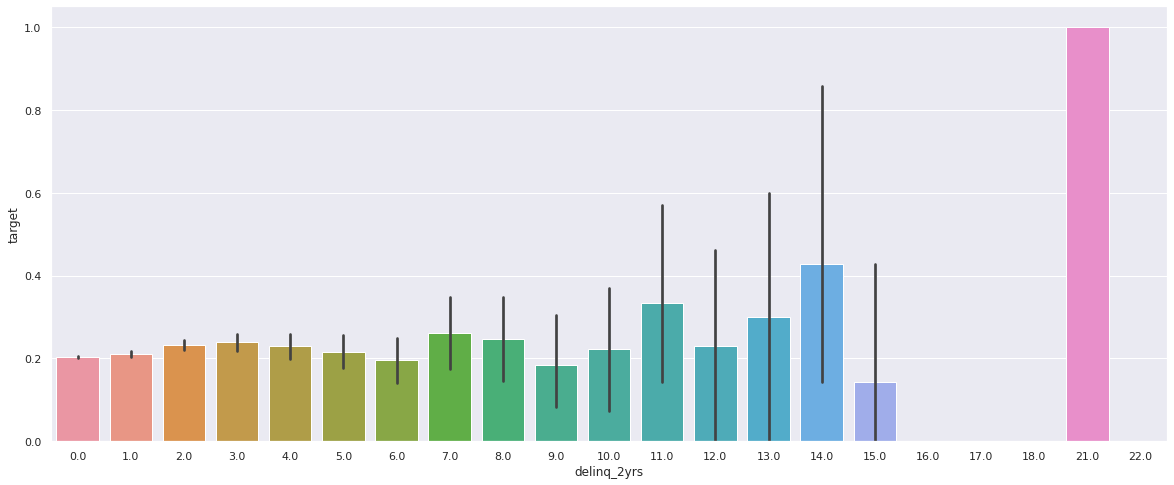

In [65]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

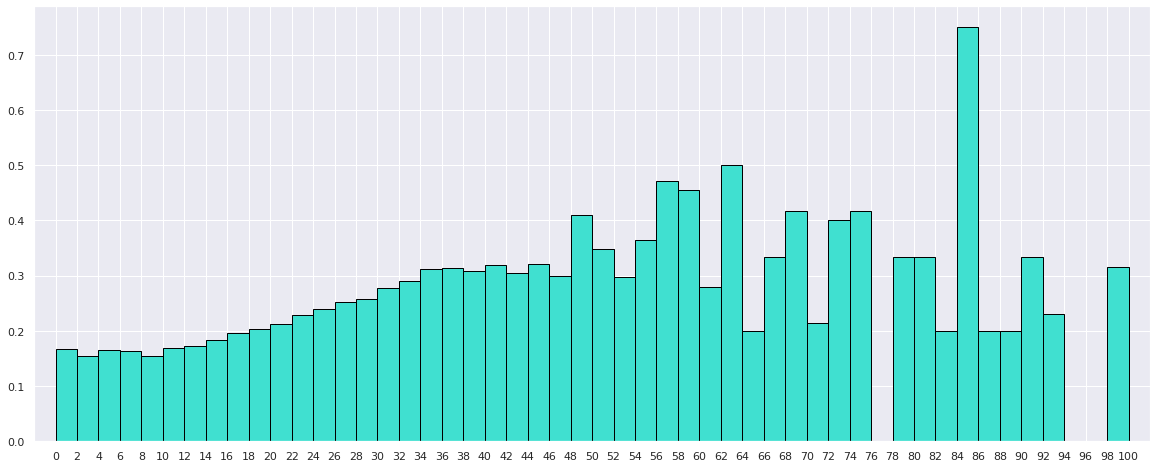

In [66]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### 5. Train-test split, missing values and feature engineering

In this section I fill missing values from train set and encode categorical features.

Depending of feature type, I use three encoding types:

- Target encoding. I do it for feature with more than 5 unique values.
- One-hot encoding. I use it for features with less than 5 unique values.
- Frequency encoding. 'Title' feature only.

In [67]:
display(df.count())

id                                124551
loan_amnt                         124551
funded_amnt                       124551
funded_amnt_inv                   124551
term                              124551
int_rate                          124551
installment                       124551
purpose                           124551
title                             123187
initial_list_status               124551
application_type                  124551
grade                             124551
sub_grade                         124551
fico_range_high                   124551
emp_title                         116095
emp_length                        116979
home_ownership                    124551
annual_inc                        124551
zip_code                          124551
addr_state                        124551
dti                               124493
verification_status               124551
mo_sin_rcnt_tl                    124551
mths_since_last_delinq            124551
mths_since_last_

In [68]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 
                     'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'bc_open_to_buy','tot_cur_bal_inc']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 
                      'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_accts_ever_120_pd',
                     'acc_open_past_24mths']

train['total_cur_bal'] = train.tot_cur_bal_inc.median()*train.annual_inc

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count())

(93414, 77)

(31137, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,8400.0,8400.0,8400.0,36.0,11.99,278.970001,debt_consolidation,Debt consolidation,f,Individual,B,B3,694.0,Project Analyst,6.0,RENT,90000.0,233,VA,6.33,Source Verified,7.0,9.0,9.0,58.0,1200.0,1200.0,2.0,3.0,0.0,0.0,10.0,4.0,7.0,26.0,30290.0,302900.0,5177.0,70.9,1600.0,7.0,4.0,5.0,7300.0,1.0,0.0,0.0,1.0,0.0,39344.0,0.0,0.0,0.000000,100.000000,0.0,0.0,1.0,0.0,0.0,1.0,2014.0,3,2014,10.666886,0.093748,0.0,0.093333,0.037196,0,0.057522,0.336556,3.365556,0.437156,0.081111,0,0.384615,0
1,10000.0,10000.0,10000.0,36.0,12.49,334.489990,credit_card,Credit card refinancing,f,Individual,B,B4,679.0,Material Handler,8.0,MORTGAGE,24500.0,647,MO,14.16,Source Verified,14.0,17.0,1200.0,1200.0,1200.0,17.0,0.0,2.0,0.0,0.0,8.0,1.0,1.0,15.0,11136.0,89091.0,11028.0,55.4,4885.0,43.0,6.0,7.0,19900.0,1.0,0.0,0.0,0.0,0.0,11028.0,0.0,0.0,75.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,4,2014,10.666886,0.000000,0.0,0.408163,0.163832,0,0.450122,0.454531,3.636367,0.450122,0.812245,0,0.533333,0
2,7700.0,7700.0,7700.0,36.0,12.49,257.559998,debt_consolidation,Debt consolidation,f,Individual,B,B5,684.0,Office Manager,2.0,OWN,20800.0,729,AR,28.51,Source Verified,13.0,7.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,18.0,5.0,0.0,30.0,497.0,8444.0,3769.0,32.2,1379.0,13.0,10.0,17.0,11700.0,2.0,0.0,0.0,0.0,0.0,8444.0,188.0,0.0,33.299999,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,10,2014,7.419728,0.000000,1.0,0.370192,0.148592,0,0.181202,0.023894,0.405962,0.405962,0.562500,0,0.600000,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,12800.0,12800.0,12800.0,36.0,18.06,463.140015,debt_consolidation,Debt consolidation,f,Individual,D,D2,679.0,Attorney,3.0,RENT,122300.0,208,MD,20.690001,Not Verified,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,1.0,1.0,10.0,7.0,0.0,23.0,16311.0,163114.0,31961.0,69.5,11086.0,5.0,4.0,6.0,46000.0,0.0,0.0,0.0,0.0,0.0,163114.0,0.0,0.0,50.0,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,2,2018,13.503357,0.000000,0.0,0.104661,0.045443,0,0.261333,0.133369,1.333720,1.333720,0.376124,0,0.434783,0
1,17600.0,17600.0,17600.0,60.0,15.61,424.359985,debt_consolidation,Clean up loan,f,Individual,C,C3,709.0,clerk,10.0,RENT,54777.0,937,CA,13.830000,Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,18.0,3333.0,23332.0,23332.0,78.0,3626.0,24.0,7.0,7.0,29900.0,0.0,0.0,0.0,0.0,0.0,23332.0,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,12,2013,22.669870,0.000000,0.0,0.321303,0.092965,0,0.425945,0.060847,0.425945,0.425945,0.545850,0,0.388889,0
2,9800.0,9800.0,9800.0,36.0,16.55,347.209991,debt_consolidation,Debt consolidation,w,Individual,D,D2,664.0,Executive Assistant,0.0,RENT,80000.0,194,PA,5.330000,Verified,3.0,71.0,71.0,76.0,74.0,74.0,6.0,2.0,0.0,0.0,6.0,7.0,0.0,25.0,3889.0,23333.0,828.0,7.4,4181.0,7.0,3.0,5.0,11200.0,0.0,0.0,0.0,1.0,1.0,23333.0,0.0,0.0,0.0,79.199997,0.0,0.0,0.0,0.0,0.0,6.0,2015.0,7,2015,32.334682,0.030927,1.0,0.122500,0.052081,0,0.010350,0.048613,0.291663,0.291663,0.140000,0,0.240000,1


loan_amnt                         93414
funded_amnt                       93414
funded_amnt_inv                   93414
term                              93414
int_rate                          93414
installment                       93414
purpose                           93414
title                             93414
initial_list_status               93414
application_type                  93414
grade                             93414
sub_grade                         93414
fico_range_high                   93414
emp_title                         93414
emp_length                        93414
home_ownership                    93414
annual_inc                        93414
zip_code                          93414
addr_state                        93414
dti                               93414
verification_status               93414
mo_sin_rcnt_tl                    93414
mths_since_last_delinq            93414
mths_since_last_major_derog       93414
mths_since_last_record            93414


In [69]:
train.bc_open_to_buy.describe()

count     93414.000000
mean      11103.050781
std       16472.355469
min           0.000000
25%        1775.000000
50%        5300.000000
75%       13465.750000
max      397338.000000
Name: bc_open_to_buy, dtype: float64

### Categorical features encoding

In [70]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

40.81141018867493

3.069383382797241

(93414, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,8400.0,8400.0,8400.0,36.0,11.99,278.970001,f,Individual,694.0,6.0,90000.0,6.330000,Source Verified,7.0,9.0,9.0,58.0,1200.0,1200.0,2.0,3.0,0.0,0.0,10.0,4.0,7.0,26.0,30290.0,302900.0,5177.0,70.9,1600.0,7.0,4.0,5.0,7300.0,1.0,0.0,0.0,1.0,0.0,39344.0,0.0,0.0,0.000000,100.000000,0.0,0.0,1.0,0.0,0.0,1.0,2014.0,3,2014,10.666886,0.093748,0.0,0.093333,0.037196,0,0.057522,0.336556,3.365556,0.437156,0.081111,0,0.384615,0,0.500343,0.134910,0.204273,0.219570,0.224469,0.150801,0.191682,0.141080,0.248931
1,10000.0,10000.0,10000.0,36.0,12.49,334.489990,f,Individual,679.0,8.0,24500.0,14.160000,Source Verified,14.0,17.0,1200.0,1200.0,1200.0,17.0,0.0,2.0,0.0,0.0,8.0,1.0,1.0,15.0,11136.0,89091.0,11028.0,55.4,4885.0,43.0,6.0,7.0,19900.0,1.0,0.0,0.0,0.0,0.0,11028.0,0.0,0.0,75.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,4,2014,10.666886,0.000000,0.0,0.408163,0.163832,0,0.450122,0.454531,3.636367,0.450122,0.812245,0,0.533333,0,0.200570,0.152333,0.362564,0.177549,0.183030,0.282564,0.231033,0.141080,0.172088
2,7700.0,7700.0,7700.0,36.0,12.49,257.559998,f,Individual,684.0,2.0,20800.0,28.510000,Source Verified,13.0,7.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,18.0,5.0,0.0,30.0,497.0,8444.0,3769.0,32.2,1379.0,13.0,10.0,17.0,11700.0,2.0,0.0,0.0,0.0,0.0,8444.0,188.0,0.0,33.299999,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,10,2014,7.419728,0.000000,1.0,0.370192,0.148592,0,0.181202,0.023894,0.405962,0.405962,0.562500,0,0.600000,0,0.500343,0.174885,0.199563,0.219570,0.224469,0.214130,0.223942,0.141080,0.213988
3,11450.0,11450.0,11450.0,36.0,10.16,370.329987,f,Individual,714.0,7.0,64000.0,24.299999,Not Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,1.0,0.0,0.0,15.0,6.0,9.0,34.0,14824.0,222359.0,39297.0,75.3,7561.0,3.0,9.0,11.0,52200.0,0.0,0.0,0.0,0.0,0.0,56802.0,0.0,0.0,42.900002,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,1,2013,15.838792,0.000000,0.0,0.178906,0.069437,0,0.614016,0.231625,3.474359,0.887531,0.815625,0,0.441176,0,0.001199,0.108331,0.206409,0.177549,0.089743,0.195771,0.228157,0.141080,0.172088
4,5000.0,5000.0,5000.0,36.0,16.02,175.839996,w,Individual,694.0,2.0,123000.0,14.940000,Verified,3.0,68.0,68.0,1200.0,73.0,73.0,6.0,0.0,6.0,9.0,9.0,10.0,5.0,27.0,8628.0,60395.0,5963.0,33.5,8537.0,7.0,1.0,6.0,17800.0,0.0,0.0,0.0,0.0,0.0,60395.0,0.0,0.0,0.000000,88.900002,2.0,3.0,0.0,0.0,0.0,3.0,2017.0,9,2017,16.085204,0.000000,0.0,0.040650,0.017155,0,0.048480,0.070146,0.491016,0.491016,0.144715,0,0.333333,0,0.060837,0.277472,0.131960,0.179718,0.183439,0.181533,0.213692,0.236803,0.172088


loan_amnt                         93414
funded_amnt                       93414
funded_amnt_inv                   93414
term                              93414
int_rate                          93414
installment                       93414
initial_list_status               93414
application_type                  93414
fico_range_high                   93414
emp_length                        93414
annual_inc                        93414
dti                               93414
verification_status               93414
mo_sin_rcnt_tl                    93414
mths_since_last_delinq            93414
mths_since_last_major_derog       93414
mths_since_last_record            93414
mths_since_recent_bc_dlq          93414
mths_since_recent_revol_delinq    93414
num_tl_op_past_12m                93414
inq_last_6mths                    93414
inq_fi                            93414
inq_last_12m                      93414
open_acc                          93414
acc_open_past_24mths              93414


In [71]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
#X_train.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_train.columns]
#X_test.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_test.columns]

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,12800.0,12800.0,12800.0,36.0,18.06,463.140015,f,Individual,679.0,3.0,122300.0,20.690001,Not Verified,5.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,1.0,1.0,10.0,7.0,0.0,23.0,16311.0,163114.0,31961.0,69.5,11086.0,5.0,4.0,6.0,46000.0,0.0,0.0,0.0,0.0,0.0,163114.0,0.0,0.0,50.0,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2018.0,2,2018,13.503357,0.000000,0.104661,0.045443,0,0.261333,0.133369,1.333720,1.333720,0.376124,0,0.434783,0,0.500343,0.309739,0.115466,0.219057,0.223662,0.176340,0.225191,0.337508,0.246135
1,17600.0,17600.0,17600.0,60.0,15.61,424.359985,f,Individual,709.0,10.0,54777.0,13.830000,Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,18.0,3333.0,23332.0,23332.0,78.0,3626.0,24.0,7.0,7.0,29900.0,0.0,0.0,0.0,0.0,0.0,23332.0,0.0,0.0,100.0,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,12,2013,22.669870,0.000000,0.321303,0.092965,0,0.425945,0.060847,0.425945,0.425945,0.545850,0,0.388889,0,0.000000,0.241442,0.212996,0.219057,0.206318,0.201299,0.205373,0.236101,0.246135
2,9800.0,9800.0,9800.0,36.0,16.55,347.209991,w,Individual,664.0,0.0,80000.0,5.330000,Verified,3.0,71.0,71.0,76.0,74.0,74.0,6.0,2.0,0.0,0.0,6.0,7.0,0.0,25.0,3889.0,23333.0,828.0,7.4,4181.0,7.0,3.0,5.0,11200.0,0.0,0.0,0.0,1.0,1.0,23333.0,0.0,0.0,0.0,79.199997,0.0,0.0,0.0,0.0,0.0,6.0,2015.0,7,2015,32.334682,0.030927,0.122500,0.052081,0,0.010350,0.048613,0.291663,0.291663,0.140000,0,0.240000,1,0.500343,0.309739,0.169807,0.219057,0.223662,0.197148,0.214089,0.337508,0.246135
3,5000.0,5000.0,5000.0,36.0,6.19,152.550003,w,Individual,744.0,4.0,53000.0,10.940000,Not Verified,6.0,62.0,1200.0,1200.0,62.0,62.0,1.0,1.0,4.0,5.0,12.0,6.0,5.0,35.0,1657.0,19889.0,0.0,0.0,31900.0,6.0,0.0,11.0,49000.0,0.0,0.0,0.0,0.0,0.0,19889.0,0.0,0.0,0.0,97.099998,1.0,0.0,0.0,0.0,0.0,0.0,2018.0,5,2018,19.083212,0.000000,0.094340,0.034540,0,0.000000,0.031264,0.375264,0.375264,0.924528,0,0.342857,0,0.019344,0.049068,0.247059,0.199746,0.209148,0.204925,0.204469,0.067608,0.246135
4,3000.0,3000.0,3000.0,36.0,7.07,92.730003,w,Individual,784.0,8.0,50500.0,18.610001,Not Verified,8.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,1.0,2.0,14.0,6.0,1.0,29.0,2405.0,33665.0,2259.0,4.5,35159.0,8.0,6.0,12.0,49800.0,0.0,0.0,0.0,0.0,0.0,33665.0,0.0,0.0,0.0,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2017.0,8,2017,14.666968,0.000000,0.059406,0.022035,0,0.044733,0.047624,0.666634,0.666634,0.986139,0,0.482759,0,0.500343,0.049068,0.180540,0.219057,0.223662,0.220313,0.205373,0.067608,0.246135


Number of features before transaformation:  (93414, 77)
time to do feature proprocessing:  3.5320751667022705
Number of features after transaformation:  (93414, 79)


,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,0.0,1.0,0.0,0.0,0.0,8400.0,8400.0,8400.0,36.0,11.99,278.970001,694.0,6.0,90000.0,6.330000,7.0,9.0,9.0,58.0,1200.0,1200.0,2.0,3.0,0.0,0.0,10.0,4.0,7.0,26.0,30290.0,302900.0,5177.0,70.9,1600.0,7.0,4.0,5.0,7300.0,1.0,0.0,0.0,1.0,0.0,39344.0,0.0,0.0,0.000000,100.000000,0.0,0.0,1.0,0.0,0.0,1.0,2014.0,3.0,2014.0,10.666886,0.093748,0.093333,0.037196,0.0,0.057522,0.336556,3.365556,0.437156,0.081111,0.0,0.384615,0.0,0.500343,0.134910,0.204273,0.219570,0.224469,0.150801,0.191682,0.141080,0.248931
1,0.0,1.0,0.0,0.0,0.0,10000.0,10000.0,10000.0,36.0,12.49,334.489990,679.0,8.0,24500.0,14.160000,14.0,17.0,1200.0,1200.0,1200.0,17.0,0.0,2.0,0.0,0.0,8.0,1.0,1.0,15.0,11136.0,89091.0,11028.0,55.4,4885.0,43.0,6.0,7.0,19900.0,1.0,0.0,0.0,0.0,0.0,11028.0,0.0,0.0,75.000000,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,4.0,2014.0,10.666886,0.000000,0.408163,0.163832,0.0,0.450122,0.454531,3.636367,0.450122,0.812245,0.0,0.533333,0.0,0.200570,0.152333,0.362564,0.177549,0.183030,0.282564,0.231033,0.141080,0.172088
2,0.0,1.0,0.0,0.0,0.0,7700.0,7700.0,7700.0,36.0,12.49,257.559998,684.0,2.0,20800.0,28.510000,13.0,7.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,18.0,5.0,0.0,30.0,497.0,8444.0,3769.0,32.2,1379.0,13.0,10.0,17.0,11700.0,2.0,0.0,0.0,0.0,0.0,8444.0,188.0,0.0,33.299999,93.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,10.0,2014.0,7.419728,0.000000,0.370192,0.148592,0.0,0.181202,0.023894,0.405962,0.405962,0.562500,0.0,0.600000,0.0,0.500343,0.174885,0.199563,0.219570,0.224469,0.214130,0.223942,0.141080,0.213988
3,1.0,0.0,0.0,0.0,0.0,11450.0,11450.0,11450.0,36.0,10.16,370.329987,714.0,7.0,64000.0,24.299999,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,1.0,0.0,0.0,15.0,6.0,9.0,34.0,14824.0,222359.0,39297.0,75.3,7561.0,3.0,9.0,11.0,52200.0,0.0,0.0,0.0,0.0,0.0,56802.0,0.0,0.0,42.900002,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,1.0,2013.0,15.838792,0.000000,0.178906,0.069437,0.0,0.614016,0.231625,3.474359,0.887531,0.815625,0.0,0.441176,0.0,0.001199,0.108331,0.206409,0.177549,0.089743,0.195771,0.228157,0.141080,0.172088
4,0.0,0.0,1.0,1.0,0.0,5000.0,5000.0,5000.0,36.0,16.02,175.839996,694.0,2.0,123000.0,14.940000,3.0,68.0,68.0,1200.0,73.0,73.0,6.0,0.0,6.0,9.0,9.0,10.0,5.0,27.0,8628.0,60395.0,5963.0,33.5,8537.0,7.0,1.0,6.0,17800.0,0.0,0.0,0.0,0.0,0.0,60395.0,0.0,0.0,0.000000,88.900002,2.0,3.0,0.0,0.0,0.0,3.0,2017.0,9.0,2017.0,16.085204,0.000000,0.040650,0.017155,0.0,0.048480,0.070146,0.491016,0.491016,0.144715,0.0,0.333333,0.0,0.060837,0.277472,0.131960,0.179718,0.183439,0.181533,0.213692,0.236803,0.172088


### 6. Modeling

Here I will build 2 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8533624510244717

'F1 score: '

0.5088209982788295

'ROCAUC: '

0.6738150530640147

'PRAUC: '

0.703006526690604

'R20P: '

0.9145907473309609

'Test Accuracy: '

0.8066930018948518

'F1 score: '

0.3403835616438356

'ROCAUC: '

0.5976486824718815

'PRAUC: '

0.45656361546642865

'R20P: '

0.6078338839075036

2.7168095111846924

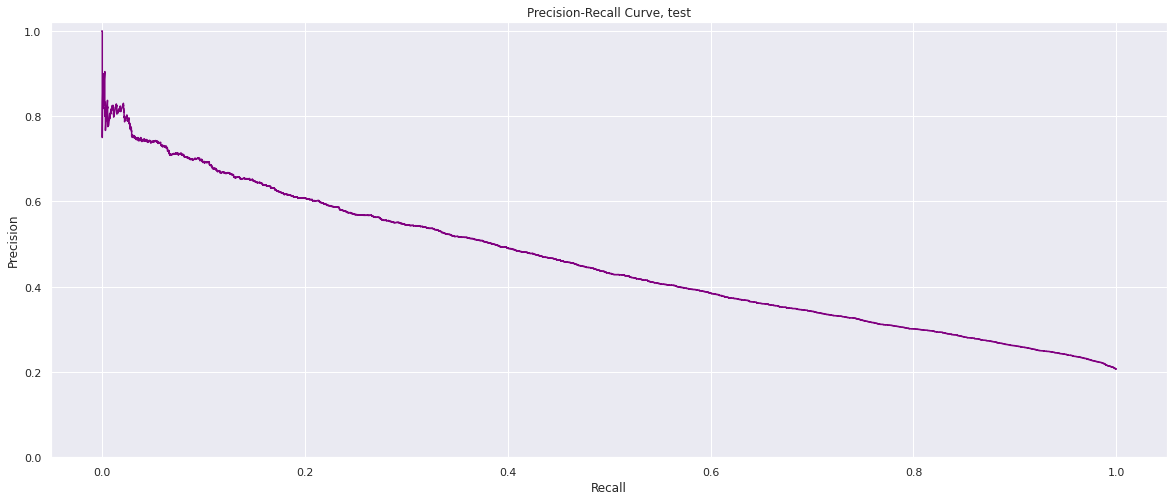

In [72]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-14 00:27:39,613] A new study created in memory with name: no-name-d0d26eb4-1dff-43e5-b514-d5770111ccc1
[I 2022-08-14 00:27:47,534] Trial 0 finished with value: 0.4276158730831118 and parameters: {'n_estimators': 972, 'max_depth': 4, 'learning_rate': 0.21641076300278123, 'colsample_bytree': 0.30225058481435085, 'subsample': 0.7226794554085323, 'alpha': 0.13311796722055644, 'lambda': 2.316579613250163, 'gamma': 7.432222611148202e-10, 'min_child_weight': 2.016310744347998}. Best is trial 0 with value: 0.4276158730831118.
[I 2022-08-14 00:27:55,322] Trial 1 finished with value: 0.47118422354207506 and parameters: {'n_estimators': 1322, 'max_depth': 2, 'learning_rate': 0.164841306429198, 'colsample_bytree': 0.23472757332056488, 'subsample': 0.5407305241939704, 'alpha': 0.9566324217511467, 'lambda': 140.9004887843452, 'gamma': 2.0858882898483573e-10, 'min_child_weight': 0.3273765784997994}. Best is trial 1 with value: 0.47118422354207506.
[I 2022-08-14 00:28:08,789] Trial 2 finish

Total time for hypermarameter optimization  451.38458609580994
        n_estimators : 1402
           max_depth : 3
       learning_rate : 0.0224220508254551
    colsample_bytree : 0.8280675446617975
           subsample : 0.8089020536726801
               alpha : 0.8448234377907987
              lambda : 0.40559913117756924
               gamma : 0.0082787357586232
    min_child_weight : 2.4662771757656166
best objective value : 0.4770361662193931


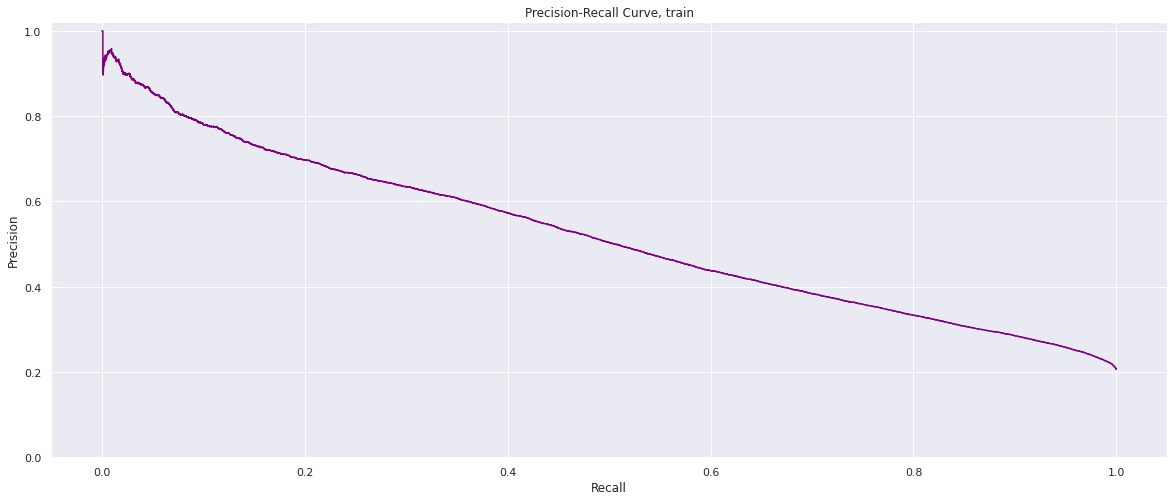

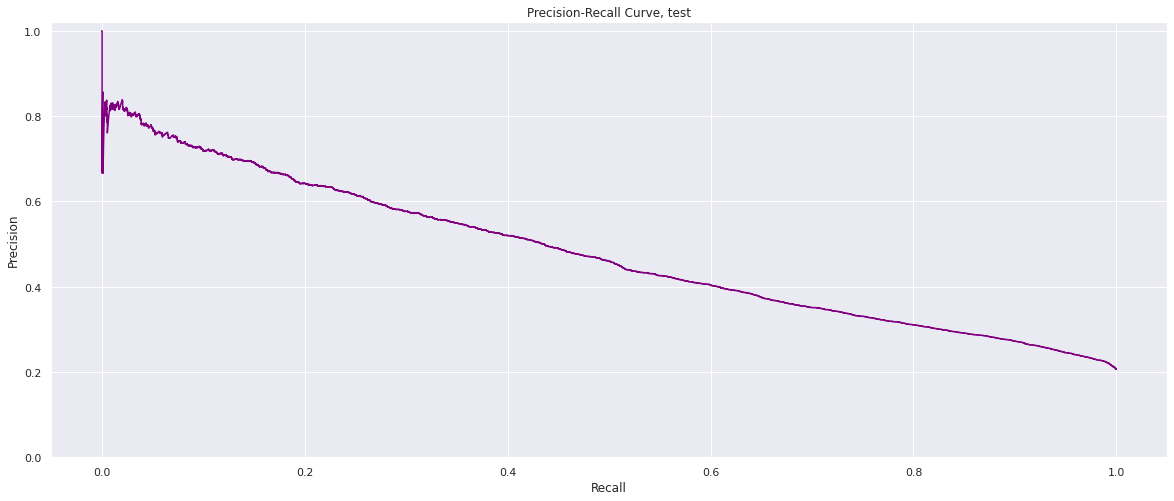

'Train Accuracy: '

0.8180465454856873

'F1 score: '

0.3372714157601279

'ROCAUC: '

0.598385335695046

'PRAUC: '

0.5208324775398644

'R20P: '

0.6979015918958031

'Test Accuracy: '

0.8128271830940681

'F1 score: '

0.32358402971216343

'ROCAUC: '

0.5923567214151382

'PRAUC: '

0.4782239872013834

'R20P: '

0.6417538614848032

'Time to do hyperparameter optimization: '

463.9232339859009

In [73]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display('Time to do hyperparameter optimization: ', time.time()-time1)

### 7. Model interpretation

In [74]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

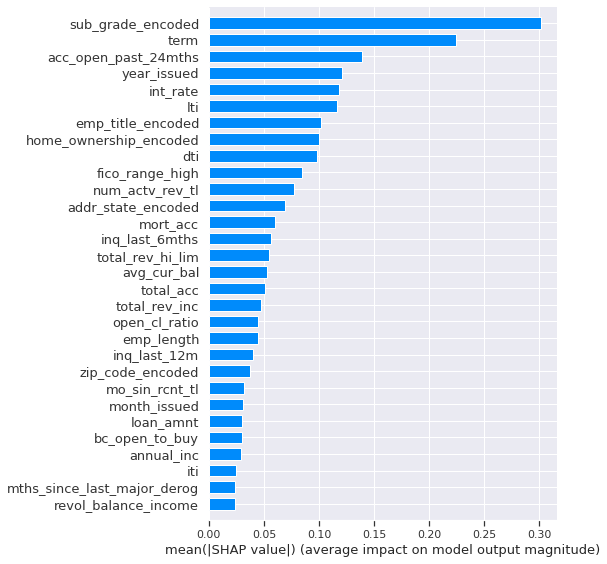

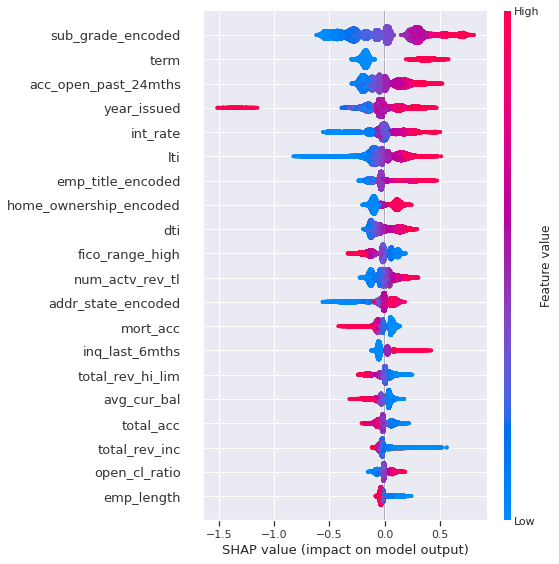

In [75]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [76]:
#indx = 1
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [77]:
time.time()-time0

523.6584446430206

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining and prediction problem, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 34%, which is not impressive. ROCAUC is 59% which is not much better than a random guess.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around one quarter of defaulted loans. For example, its precision at 20% recall is 69%. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 20% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

While trying to quantify value created by the model, I will make a few assumptions about Lending Club business structure. They will be imperfect. The purpose of this section is to get back-of-the-envelope approximation of the increase in operational profit of Lending Club from using the model rather then build financial model of Lending Club.

The decision to refuse originating x% of the riskiest loans is a tradoeff between a foregone interest income and a credit loss. 

If Lending Club issues a loan:
- It receives interest income in the future as long as the borrower repays a loan.
- It suffers credit losses if the borrower defaults.

Thus the decision to issue such loans depends on which part dominates.

To quantify interest income, first we have to figure out cost of capital of Lending Club. Since Lending Club is not a bank, it can not borrow from the Fed at a refinance rate. It is unlikely to be able to borrow from banks at LIBOR either. I assume it can raise funding in financial markets at a rate worse than LIBOR but better than prime rate. Total cost of capital is a weighted average between cost of debt and cost of equity. Cost of equity is always higher. As of 2018, equity was around 20% of Lending Club capital. So cost of debt is the most imortant part in the cost of capital of Lending Club. Thus I assume that total cost of capital of Lending Club is roughly prime rate. Over the sample period of my data, average prime rate [was around 5%](https://fred.stlouisfed.org/series/DPRIME).

Therefore, potential interest income = Loan amount*(Interest rate-5%).

To quantify credit losses I subtract recovered amount from loan amount.

In order to keep this analysis simple and accessible to wider audience I abstract away from time discounting and present value calculations.

Thus the value created by refusing top x% riskiest (as predicted by the model) loans is $$\sum_{i \in DefaultedLoans}(LoanAmount_i - Recovery_i) - \sum_{j \in RepaidLoans}(LoanAmount_j*(InterestRate_j-5\%))$$. 





In [78]:
I

NameError: name 'I' is not defined

In [ ]:
X_test['y_pred'] = optuna_xgb.predict_proba(X_test)[:,1]
display(recoveries.head(), X_test.head())